In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [41]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 1             # 추출할 주파수 개수
design_region_resolution = 50

In [51]:
tag_bot         = 0.5
tag_side        = 4
tsio2           = 4
monitor_position =  1 / fcen * 2
monitor_blank   = 1 / fcen * 0.1

tpml = 0.4

width_ag = 0.2
width_sio2 = 2

width_bot_ag = width_ag+width_sio2+width_ag

design_region_width = round(width_bot_ag, 3)
design_region_height = 0.5

Sx = tpml+width_bot_ag+tpml
Sy = round(tag_bot+tag_side+design_region_height+monitor_position+monitor_blank+tpml, 1)

SiO2 = mp.Medium(index = 1.45)
TiO2 = mp.Medium(index = 2.6)

Nx = int(design_region_resolution * design_region_width) + 1
# Ny = int(design_region_resolution * design_region_height) + 1
Ny = 1

y_bottom = -Sy/2
center_y_ag = y_bottom + tag_bot / 2
center_y_sio2 = y_bottom + tag_bot + tsio2 / 2
center_y_design = y_bottom + tag_bot + tsio2 + design_region_height / 2
center_y_monitor_position = y_bottom + tag_bot + tsio2 + design_region_height + monitor_position
center_y_source_position = y_bottom + tag_bot + 1/fcen 
center_Ag_x_position = design_region_width/2-width_ag/2 #+ tpml/2

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), TiO2, SiO2,  grid_type="U_MEAN")

boundary_layers = [mp.Absorber(tpml,direction=mp.X),
                   mp.PML(tpml,direction=mp.Y,side=mp.High)]

In [52]:
# 셀 크기 설정
cell_size = mp.Vector3(Sx, Sy)

# 기본 지오메트리 정의
geometry = [
    # Bottom Ag layer
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    # SiO2 layer
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    # Side metal
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
    ),
]


In [53]:
# 몇개의 layer로 최적화를 할건지 설정하고 싶다면 layer_num 갯수 조절
layer_num = 1

ML = (layer_num > 1)

region_height_each = design_region_height / layer_num
full_center_y = y_bottom + tag_bot + tsio2 + design_region_height/2

if ML:
    design_variables = []
    design_region = []
    for dv in range(layer_num):
        mg = mp.MaterialGrid(
            mp.Vector3(Nx, Ny),
            TiO2,       
            SiO2,       
            grid_type="U_MEAN",
            do_averaging=False
        )
        design_variables.append(mg)
        offset = ((layer_num - 1) / 2 - dv) * region_height_each
        center_y = full_center_y + offset

        dr = mpa.DesignRegion(
            mg,
            volume=mp.Volume(
                center=mp.Vector3(0, center_y, 0),
                size=mp.Vector3(design_region_width, region_height_each, 0),
            ),
        )
        design_region.append(dr)

        geometry.append(
            mp.Block(
                material=design_variables[dv],
                size=design_region[dv].size,
                center=design_region[dv].center
            )
        )
else:
    design_variables = mp.MaterialGrid(
        mp.Vector3(Nx, Ny),
        TiO2,
        SiO2,
        grid_type="U_MEAN",
        do_averaging=False
    )
    design_region = mpa.DesignRegion(
        design_variables,
        volume=mp.Volume(
            center=mp.Vector3(0, full_center_y, 0),
            size=mp.Vector3(design_region_width, region_height_each, 0),
        )
    )
    geometry.append(
        mp.Block(
            material=design_variables,
            size=design_region.size,
            center=design_region.center
        )
    )


In [54]:
src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)

sources = mp.Source(
            src,
            component=mp.Ez,
            center=mp.Vector3(
                0,
                center_y_source_position,  # Alq3 층의 중간 높이
                0
            )
        )

sim = mp.Simulation(
    resolution=resolution,
    sources=[sources],
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry,
    default_material=mp.Medium(index = 1),
    extra_materials=[Ag]
)

     block, center = (0,-3,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.75,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.75,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.75,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.5,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)


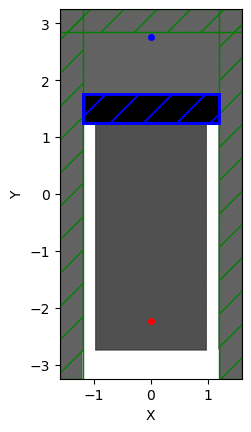

In [55]:
monitor_position_J, monitor_size = mp.Vector3(0, center_y_monitor_position), mp.Vector3(0,0)
FourierFields = mpa.FourierFields(sim,mp.Volume(center=monitor_position_J,size=monitor_size),mp.Ez,yee_grid=True)
ob_list = [FourierFields]

def J(fields):
    return npa.mean(npa.real(fields) ** 2) # The index 1 corresponds to the point at the center of our monitor.

opt = mpa.OptimizationProblem(
            simulation=sim,
            objective_functions=[J],
            objective_arguments=ob_list,
            design_regions=design_region,        # 한 개의 DesignRegion
            frequencies=[fcen],
            maximum_run_time=300,
        )

opt.plot2D(True)

In [56]:
class AdamOptimizer:
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, warmup_iters=10):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mt = None
        self.vt = None
        self.iter = 0
        self.warmup_iters = warmup_iters
    
    def update(self, v, gradient):
        if self.mt is None:
            self.mt = np.zeros_like(v)
        if self.vt is None:
            self.vt = np.zeros_like(v)
            
        #Adam에서는 기울기 값과 기울기의 제곱값의 지수이동평균을 활용하여 step 변회량을 조절
        self.iter += 1
        self.mt = self.beta1 * self.mt + (1 - self.beta1) * gradient           #m_(t)=beta_(1)*m_(t-1)+(1-beta_(1))*gradient
        self.vt = self.beta2 * self.vt + (1 - self.beta2) * (gradient ** 2)       #v_(t)=beta_(2)*v_(t-1)+(1-beta_(2))*(gradeint^2)
        
        # 초기 몇번의 update에서 0으로 편향되어 있어서 출발 지점에서 멀리 떨어진 곳으로 이동하는, 초기 경로의 편향 문제를 해결 하기 위해 unbiased하게 만들어줌
        m_hat = self.mt / (1 - self.beta1 ** self.iter)   #m_hat=m/(1-beta1**t)
        v_hat = self.vt / (1 - self.beta2 ** self.iter)
        
        # Warm-up 단계
        if self.iter <= self.warmup_iters:
            warmup_factor = self.iter / self.warmup_iters
            lr = self.lr * warmup_factor
        else:
            lr = self.lr   #lr_t <- alpha*sqrt
            
        #update = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        update_factor= m_hat / (np.sqrt(v_hat) + self.epsilon) #theta_t <- theta_(t-1)-alpha_(t)*m_(t)/(sqrt(v_(t))+epsilon) alpha_(t)=learning rate
        update = lr * update_factor
        updated_v = v + update
        updated_v = np.clip(updated_v, 0.0, 1.0)
        
        adam_lr=np.mean(np.abs(update))
        adam_uf=np.mean(np.abs(update_factor))
        
        # adam_beta1=self.beta1
        # # adam_beta2=self.beta2
        adam_m=self.mt
        adam_v=self.vt
        adam_t=self.iter
        
        return updated_v, adam_lr, adam_uf, adam_m, adam_v, adam_t

In [57]:
eta_i = 0.5
def multi_mapping(x, eta_i, beta):
    size_each = Nx * Ny
    v3 = x.reshape(layer_num, size_each)

    rho_list = []
    for i in range(layer_num):
        layer_field = v3[i].reshape(Nx, Ny)
        layer_field = (np.flipud(layer_field) + layer_field) / 2
        flat = layer_field.flatten()
        proj = mpa.tanh_projection(flat, beta, eta_i)
        rho_list.append(proj)          

    stacked = np.concatenate(rho_list, axis=0)  
    return stacked


In [58]:
eta_i = 0.5

def multi_mapping_ad(x, eta, beta):    
    size_each = Nx * Ny

    v3 = x.reshape(layer_num, size_each)

    rho_list = []
    for i in range(layer_num):
        layer_field = v3[i].reshape(Nx, Ny)
        sym_field   = (layer_field[::-1, :] + layer_field) / 2
        flat        = sym_field.ravel()
        proj        = mpa.tanh_projection(flat, beta, eta)
        rho_list.append(proj)

    return npa.concatenate(rho_list, axis=0)



--- Iter 1 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.04689867368898295
Binary degree : 0.4121584040038059 


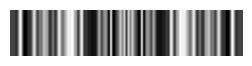


--- Iter 2 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.048761067101239036
Binary degree : 0.41263348791839516 


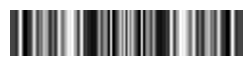


--- Iter 3 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.0525954098890475
Binary degree : 0.4137172219103487 


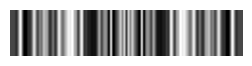


--- Iter 4 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.058566680086770566
Binary degree : 0.41525754498216494 


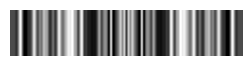


--- Iter 5 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.06676777524387295
Binary degree : 0.4171537738446537 


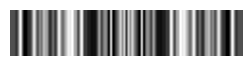


--- Iter 6 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.0771497001952949
Binary degree : 0.4196611825274688 


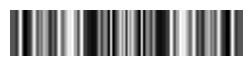


--- Iter 7 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.08942850989847843
Binary degree : 0.42189498573836987 


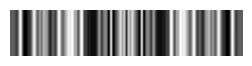


--- Iter 8 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.10232616708501649
Binary degree : 0.4232158359514736 


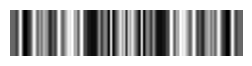


--- Iter 9 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.11354689755241408
Binary degree : 0.42424100451761143 


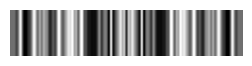


--- Iter 10 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.12205233308529982
Binary degree : 0.42475205974695845 


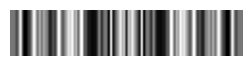


--- Iter 11 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.13126626624812043
Binary degree : 0.42629328047979004 


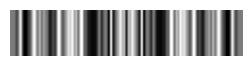


--- Iter 12 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.14420638146218373
Binary degree : 0.42944324477582924 


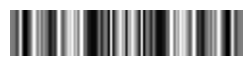


--- Iter 13 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.16231574289558326
Binary degree : 0.4340340911552496 


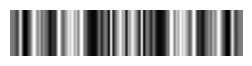


--- Iter 14 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.18162041513592342
Binary degree : 0.4384277936995738 


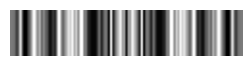


--- Iter 15 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.19519846983819703
Binary degree : 0.44371939332103416 


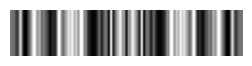


--- Iter 16 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.20738734748854504
Binary degree : 0.4510931102031758 


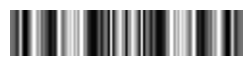


--- Iter 17 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.21888794867059191
Binary degree : 0.4582039281384841 


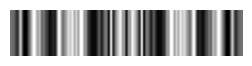


--- Iter 18 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.23319988547732673
Binary degree : 0.4660638313153513 


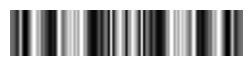


--- Iter 19 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.2531411253606016
Binary degree : 0.4739548898888616 


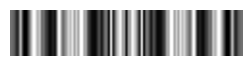


--- Iter 20 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.2751400491943469
Binary degree : 0.480421618579927 


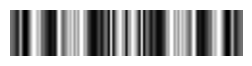


--- Iter 21 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.2973066563404841
Binary degree : 0.48969566292493755 


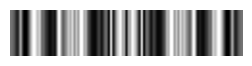


--- Iter 22 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.3224937959772702
Binary degree : 0.49945952906126295 


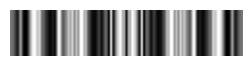


--- Iter 23 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.35296150085578315
Binary degree : 0.5083168623187716 


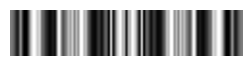


--- Iter 24 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.3906716908628072
Binary degree : 0.5172325461647683 


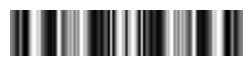


--- Iter 25 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.43022551259362335
Binary degree : 0.5282411983463466 


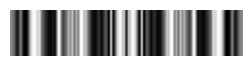


--- Iter 26 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.4533811263948586
Binary degree : 0.5393554918086354 


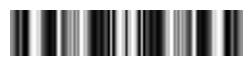


--- Iter 27 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.4675869012858606
Binary degree : 0.5503535610259338 


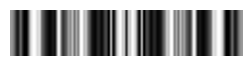


--- Iter 28 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.45507763640305604
Binary degree : 0.557721816165848 


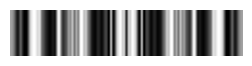


--- Iter 29 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.5079578227836111
Binary degree : 0.5657056505425949 


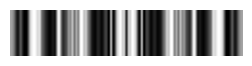


--- Iter 30 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.5201009639743056
Binary degree : 0.572130807152938 


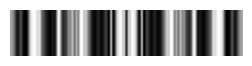


--- Iter 31 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.5273002772552439
Binary degree : 0.5772096760313663 


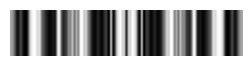


--- Iter 32 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.5371136872933752
Binary degree : 0.5830545616028 


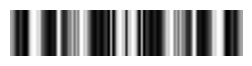


--- Iter 33 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.5727597731809851
Binary degree : 0.5892866974382565 


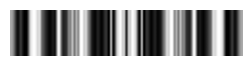


--- Iter 34 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.5953314276724159
Binary degree : 0.5958280741690587 


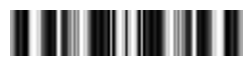


--- Iter 35 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.5998771519726042
Binary degree : 0.60234838130711 


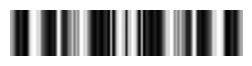


--- Iter 36 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.6281715619702928
Binary degree : 0.6081981896654005 


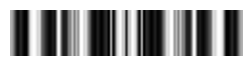


--- Iter 37 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.6494263001348473
Binary degree : 0.6134827996548262 


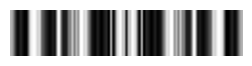


--- Iter 38 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.6642348067582272
Binary degree : 0.6185759847182418 


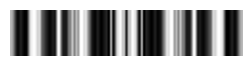


--- Iter 39 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.6759032529497179
Binary degree : 0.6233870687039624 


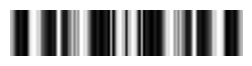


--- Iter 40 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.7076134491142587
Binary degree : 0.6276277125547375 


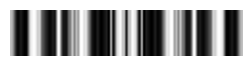


--- Iter 41 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.7282062479524082
Binary degree : 0.6317628160533293 


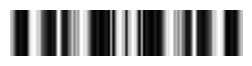


--- Iter 42 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.7388006922779324
Binary degree : 0.6374215192137848 


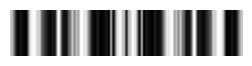


--- Iter 43 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.7854207522512094
Binary degree : 0.6429144597576134 


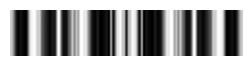


--- Iter 44 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.8105372596794364
Binary degree : 0.6481842154209524 


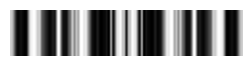


--- Iter 45 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.8394240628839642
Binary degree : 0.6528964799818782 


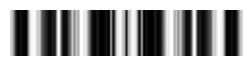


--- Iter 46 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.8824482142546001
Binary degree : 0.6574862603006774 


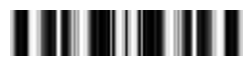


--- Iter 47 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.8734524455775284
Binary degree : 0.660749466353693 


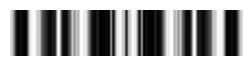


--- Iter 48 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.9343360371685816
Binary degree : 0.6644870558670299 


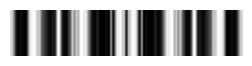


--- Iter 49 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.9360042763926337
Binary degree : 0.6661464688333101 


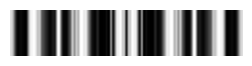


--- Iter 50 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.9907294055679985
Binary degree : 0.6681510945618669 


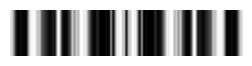


--- Iter 51 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.0134443443580377
Binary degree : 0.668883974350294 


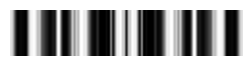


--- Iter 52 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.0317310717882018
Binary degree : 0.668562685771756 


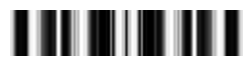


--- Iter 53 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.051282037174988
Binary degree : 0.668009371155358 


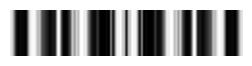


--- Iter 54 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 0.9344204454867775
Binary degree : 0.6673924370105287 


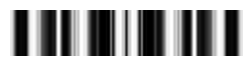


--- Iter 55 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.0798893739291398
Binary degree : 0.6676294590305216 


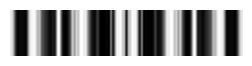


--- Iter 56 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.1228546421286183
Binary degree : 0.6673418886556598 


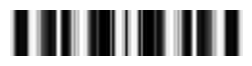


--- Iter 57 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.062729251077312
Binary degree : 0.6668491408746378 


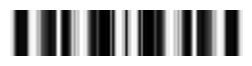


--- Iter 58 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.122377034045613
Binary degree : 0.6680409556447556 


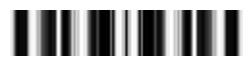


--- Iter 59 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.1569250490924967
Binary degree : 0.6677603927145679 


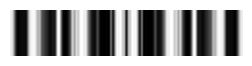


--- Iter 60 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.1554425949481477
Binary degree : 0.6678255726787933 


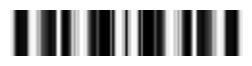


--- Iter 61 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.145335700898909
Binary degree : 0.6686606466609727 


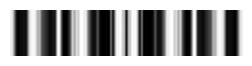


--- Iter 62 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.1468737854315332
Binary degree : 0.6679771610241687 


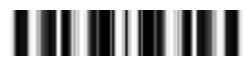


--- Iter 63 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.193831559025307
Binary degree : 0.6690333247597229 


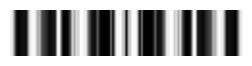


--- Iter 64 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.1806091279035067
Binary degree : 0.6699836261657371 


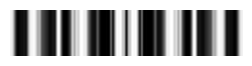


--- Iter 65 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.1495241711127537
Binary degree : 0.669754747692491 


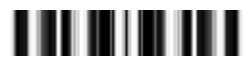


--- Iter 66 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.1768252856674413
Binary degree : 0.6715673834335818 


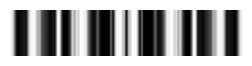


--- Iter 67 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.2112779311298587
Binary degree : 0.6718774504969666 


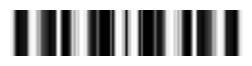


--- Iter 68 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.207039693206708
Binary degree : 0.6725052057618023 


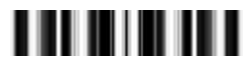


--- Iter 69 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.1727124369055046
Binary degree : 0.6740494233710195 


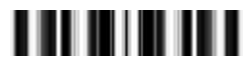


--- Iter 70 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.188494705178732
Binary degree : 0.6737639294570342 


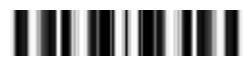


--- Iter 71 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.201907910320511
Binary degree : 0.6752815550428002 


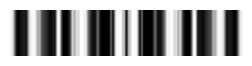


--- Iter 72 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.2103035373968383
Binary degree : 0.6758827280495872 


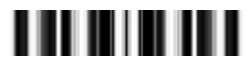


--- Iter 73 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.2034054648373815
Binary degree : 0.6759825145305274 


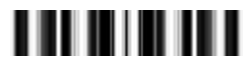


--- Iter 74 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.1722902191013551
Binary degree : 0.6774885155462207 


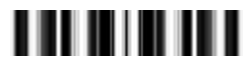


--- Iter 75 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.207676846117501
Binary degree : 0.6771811318874921 


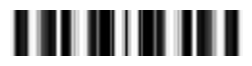


--- Iter 76 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.2130403163015218
Binary degree : 0.6782279226278869 


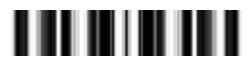


--- Iter 77 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.2065147470615953
Binary degree : 0.6789227515821317 


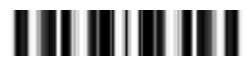


--- Iter 78 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.2108284931179913
Binary degree : 0.6788458267426005 


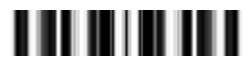


--- Iter 79 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.193883755707412
Binary degree : 0.6801562271121977 


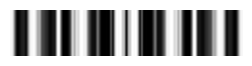


--- Iter 80 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.222881932604586
Binary degree : 0.680124026930284 


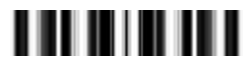


--- Iter 81 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.2242596970515376
Binary degree : 0.6808412319804473 


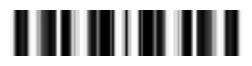


--- Iter 82 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.211725582182546
Binary degree : 0.6817432122719038 


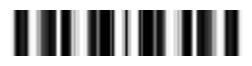


--- Iter 83 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.2210777128669392
Binary degree : 0.6819941774630834 


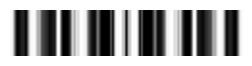


--- Iter 84 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.2112288309268795
Binary degree : 0.6831440227056826 


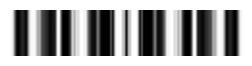


--- Iter 85 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.2338751642612038
Binary degree : 0.683430356529999 


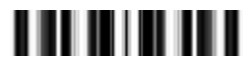


--- Iter 86 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.2352101312084112
Binary degree : 0.6841373591174953 


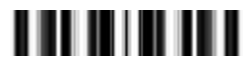


--- Iter 87 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.2258011866895284
Binary degree : 0.6849007325209159 


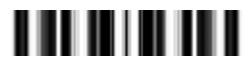


--- Iter 88 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.231863563392766
Binary degree : 0.6850617863895626 


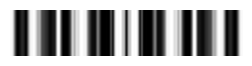


--- Iter 89 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.222009839843413
Binary degree : 0.6859571945517275 


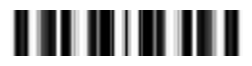


--- Iter 90 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.2397165743337715
Binary degree : 0.6860183685247252 


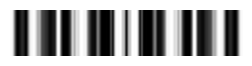


--- Iter 91 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.2400465264408564
Binary degree : 0.686599628062899 


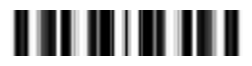


--- Iter 92 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2
Current FOM: 1.2400016068050843
Binary degree : 0.686978456009219 


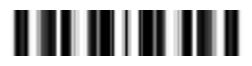


--- Iter 93 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.0749943755062037
Current FOM: 1.2415179129578628
Binary degree : 0.6870780641266502 


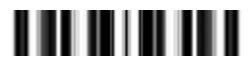


--- Iter 94 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.153737583356691
Current FOM: 1.1485253034259169
Binary degree : 0.691329633062976 


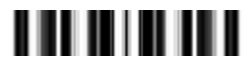


--- Iter 95 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.153737583356691
Current FOM: 1.1259480837138338
Binary degree : 0.6933221910214892 


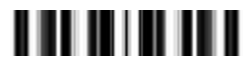


--- Iter 96 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.153737583356691
Current FOM: 1.246759670424108
Binary degree : 0.6935117355153917 


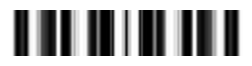


--- Iter 97 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.153737583356691
Current FOM: 1.1206641261131283
Binary degree : 0.6937347842978459 


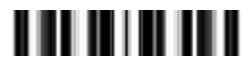


--- Iter 98 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.153737583356691
Current FOM: 1.1930471984350843
Binary degree : 0.6920498037084999 


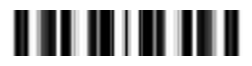


--- Iter 99 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.153737583356691
Current FOM: 1.2450994226649532
Binary degree : 0.692075709989767 


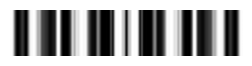


--- Iter 100 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.153737583356691
Current FOM: 1.105548278746124
Binary degree : 0.6926302838554994 


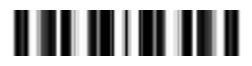


--- Iter 101 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.153737583356691
Current FOM: 1.1600610750338352
Binary degree : 0.6911116949923812 


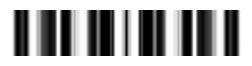


--- Iter 102 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.153737583356691
Current FOM: 1.2385193370775436
Binary degree : 0.690592330350004 


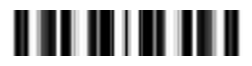


--- Iter 103 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.153737583356691
Current FOM: 1.174416022939591
Binary degree : 0.6902304178765681 


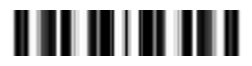


--- Iter 104 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.153737583356691
Current FOM: 1.2392581967902543
Binary degree : 0.6886405040740045 


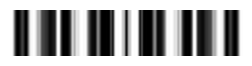


--- Iter 105 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.153737583356691
Current FOM: 1.238885457585888
Binary degree : 0.6882357134383782 


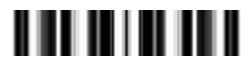


--- Iter 106 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.153737583356691
Current FOM: 1.2153678166944144
Binary degree : 0.688683827889069 


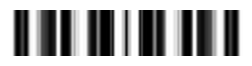


--- Iter 107 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.153737583356691
Current FOM: 1.2419767047290826
Binary degree : 0.6884165907580421 


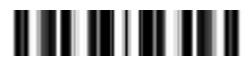


--- Iter 108 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.153737583356691
Current FOM: 1.2017604867319347
Binary degree : 0.6881337670052475 


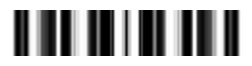


--- Iter 109 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.153737583356691
Current FOM: 1.2166457922629301
Binary degree : 0.6884262724217137 


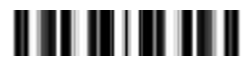


--- Iter 110 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.153737583356691
Current FOM: 1.2525101114456014
Binary degree : 0.6880496571858981 


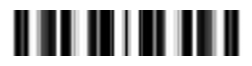


--- Iter 111 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.153737583356691
Current FOM: 1.2493412277843814
Binary degree : 0.6876138235161641 


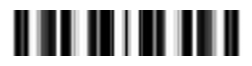


--- Iter 112 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.153737583356691
Current FOM: 1.2566826850852986
Binary degree : 0.6882370685826593 


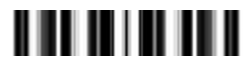


--- Iter 113 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.153737583356691
Current FOM: 1.237712840322745
Binary degree : 0.6888835762973324 


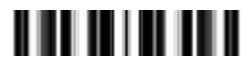


--- Iter 114 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.153737583356691
Current FOM: 1.2521848324675413
Binary degree : 0.689023380200091 


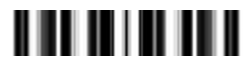


--- Iter 115 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.153737583356691
Current FOM: 1.2474429696483924
Binary degree : 0.689713674303882 


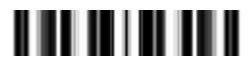


--- Iter 116 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.153737583356691
Current FOM: 1.2192200740031767
Binary degree : 0.6904895980312391 


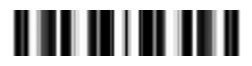


--- Iter 117 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.153737583356691
Current FOM: 1.2483631425252304
Binary degree : 0.6903803989238246 


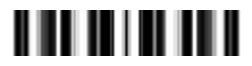


--- Iter 118 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.153737583356691
Current FOM: 1.2555414717428777
Binary degree : 0.6905037560295966 


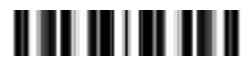


--- Iter 119 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.153737583356691
Current FOM: 1.2427279417101542
Binary degree : 0.6910025256477264 


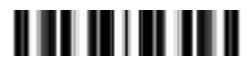


--- Iter 120 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.153737583356691
Current FOM: 1.2598639073643303
Binary degree : 0.6910528828729542 


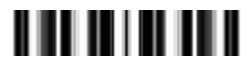


--- Iter 121 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.153737583356691
Current FOM: 1.2556188030979103
Binary degree : 0.691264613607127 


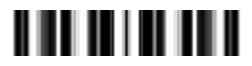


--- Iter 122 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.153737583356691
Current FOM: 1.244587784109652
Binary degree : 0.6919699854073587 


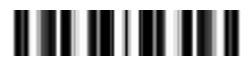


--- Iter 123 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.153737583356691
Current FOM: 1.2429196158169458
Binary degree : 0.6922603570800123 


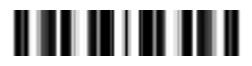


--- Iter 124 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.153737583356691
Current FOM: 1.242624905965658
Binary degree : 0.6922530587184871 


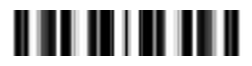


--- Iter 125 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.236416925480842
Current FOM: 1.249087098055393
Binary degree : 0.6925398324578429 


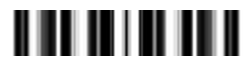


--- Iter 126 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.236416925480842
Current FOM: 1.1850285819555963
Binary degree : 0.6962925120539402 


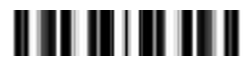


--- Iter 127 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.236416925480842
Current FOM: 1.1082114590037844
Binary degree : 0.6946558846408567 


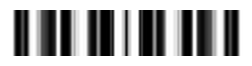


--- Iter 128 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.236416925480842
Current FOM: 1.254993658098028
Binary degree : 0.6949983884657815 


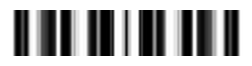


--- Iter 129 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.236416925480842
Current FOM: 1.0675687414361905
Binary degree : 0.6956423260940234 


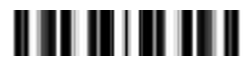


--- Iter 130 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.236416925480842
Current FOM: 1.2607099827250845
Binary degree : 0.6945692217759392 


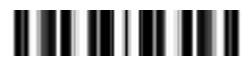


--- Iter 131 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.236416925480842
Current FOM: 1.1659280776772962
Binary degree : 0.6939179827501072 


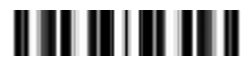


--- Iter 132 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.236416925480842
Current FOM: 1.2303228928882168
Binary degree : 0.6945190090104234 


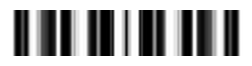


--- Iter 133 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.236416925480842
Current FOM: 1.1908105535329716
Binary degree : 0.6944094841218804 


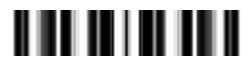


--- Iter 134 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.236416925480842
Current FOM: 1.1948183254327946
Binary degree : 0.6932031382272629 


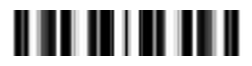


--- Iter 135 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.236416925480842
Current FOM: 1.2544608637165524
Binary degree : 0.6928354712050053 


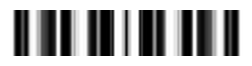


--- Iter 136 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.236416925480842
Current FOM: 1.1823411818714986
Binary degree : 0.6927106239676085 


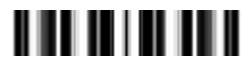


--- Iter 137 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.236416925480842
Current FOM: 1.2618905529452802
Binary degree : 0.6915576249884458 


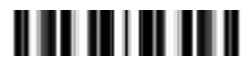


--- Iter 138 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.236416925480842
Current FOM: 1.2335675918576423
Binary degree : 0.6909166519308875 


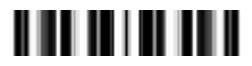


--- Iter 139 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.236416925480842
Current FOM: 1.2446105313369469
Binary degree : 0.6913285339958434 


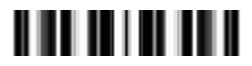


--- Iter 140 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.236416925480842
Current FOM: 1.2231220174589912
Binary degree : 0.6913717140437748 


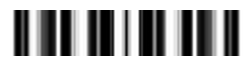


--- Iter 141 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.236416925480842
Current FOM: 1.226650691339288
Binary degree : 0.6907583255245547 


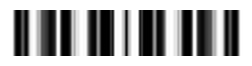


--- Iter 142 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.236416925480842
Current FOM: 1.2497240985598594
Binary degree : 0.6906858819168568 


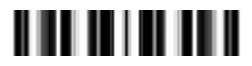


--- Iter 143 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.236416925480842
Current FOM: 1.2272314986748325
Binary degree : 0.6907301732089287 


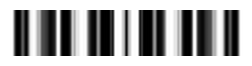


--- Iter 144 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.236416925480842
Current FOM: 1.2637654893191994
Binary degree : 0.6905570968572681 


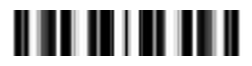


--- Iter 145 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.236416925480842
Current FOM: 1.2572495498632754
Binary degree : 0.6906645823870736 


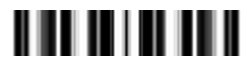


--- Iter 146 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.236416925480842
Current FOM: 1.253564454258553
Binary degree : 0.6912010389071908 


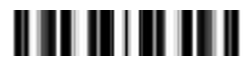


--- Iter 147 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.236416925480842
Current FOM: 1.2449048992882765
Binary degree : 0.6916917595551585 


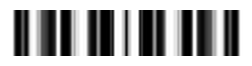


--- Iter 148 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.236416925480842
Current FOM: 1.2439546987892043
Binary degree : 0.6919630986736539 


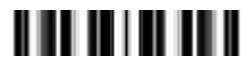


--- Iter 149 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.236416925480842
Current FOM: 1.2503826720160263
Binary degree : 0.6922352228559165 


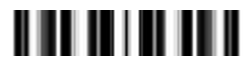


--- Iter 150 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.236416925480842
Current FOM: 1.2416578554496998
Binary degree : 0.6923924927640923 


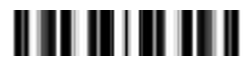


--- Iter 151 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.236416925480842
Current FOM: 1.2621678020260512
Binary degree : 0.6923051355740605 


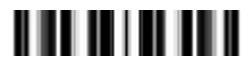


--- Iter 152 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.236416925480842
Current FOM: 1.2612984089624522
Binary degree : 0.6924165036806942 


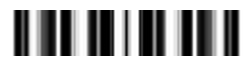


--- Iter 153 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.236416925480842
Current FOM: 1.2553752241666116
Binary degree : 0.6928112727452929 


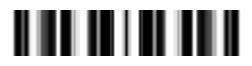


--- Iter 154 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.323229046896115
Current FOM: 1.2535496232200904
Binary degree : 0.6931696372478195 


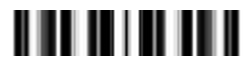


--- Iter 155 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.4143803993961126
Current FOM: 1.2130165298500588
Binary degree : 0.6972640403984709 


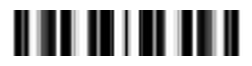


--- Iter 156 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.4143803993961126
Current FOM: 1.2048508116639032
Binary degree : 0.7007843655606864 


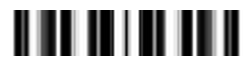


--- Iter 157 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.4143803993961126
Current FOM: 1.215190478385882
Binary degree : 0.6998763933163221 


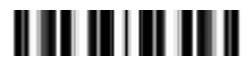


--- Iter 158 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.4143803993961126
Current FOM: 1.2100904654951983
Binary degree : 0.6992595510848137 


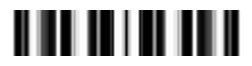


--- Iter 159 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.4143803993961126
Current FOM: 1.236262445995465
Binary degree : 0.698554708993814 


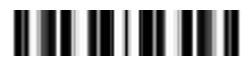


--- Iter 160 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.4143803993961126
Current FOM: 1.2345570104179346
Binary degree : 0.6980599138315601 


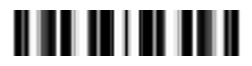


--- Iter 161 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.4143803993961126
Current FOM: 1.2569004685129463
Binary degree : 0.6983585971052164 


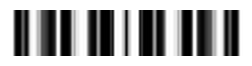


--- Iter 162 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.4143803993961126
Current FOM: 1.183373765633755
Binary degree : 0.6985604455719365 


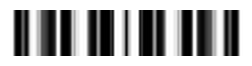


--- Iter 163 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.4143803993961126
Current FOM: 1.1878364999809463
Binary degree : 0.6981019818354856 


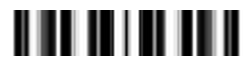


--- Iter 164 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.4143803993961126
Current FOM: 1.2409620600367752
Binary degree : 0.697184051176569 


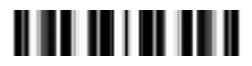


--- Iter 165 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.4143803993961126
Current FOM: 1.2273070368691075
Binary degree : 0.696283279819023 


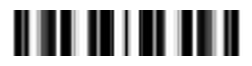


--- Iter 166 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.4143803993961126
Current FOM: 1.250716071735998
Binary degree : 0.695443356364042 


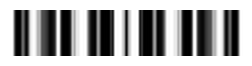


--- Iter 167 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.4143803993961126
Current FOM: 1.2525120071886522
Binary degree : 0.6953946833661573 


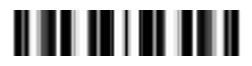


--- Iter 168 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.4143803993961126
Current FOM: 1.238978122598542
Binary degree : 0.6959751935827077 


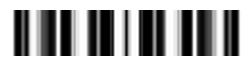


--- Iter 169 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.4143803993961126
Current FOM: 1.2408761868844773
Binary degree : 0.6964320540063466 


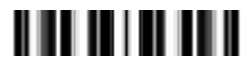


--- Iter 170 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.4143803993961126
Current FOM: 1.2189772921788136
Binary degree : 0.6966978949477387 


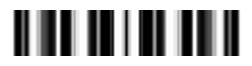


--- Iter 171 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.4143803993961126
Current FOM: 1.226954057582316
Binary degree : 0.6966325466091333 


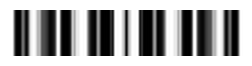


--- Iter 172 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.4143803993961126
Current FOM: 1.253913102413293
Binary degree : 0.6961370478163671 


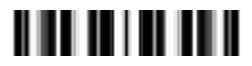


--- Iter 173 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.4143803993961126
Current FOM: 1.2610943530566965
Binary degree : 0.695667086494455 


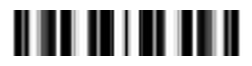


--- Iter 174 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.4143803993961126
Current FOM: 1.2588225587249926
Binary degree : 0.695680656349508 


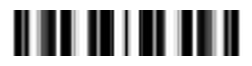


--- Iter 175 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.4143803993961126
Current FOM: 1.254290910339697
Binary degree : 0.6958607705833955 


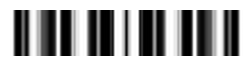


--- Iter 176 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.5100877278774254
Current FOM: 1.2582698298081245
Binary degree : 0.6960346053034965 


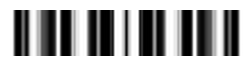


--- Iter 177 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.610578580351395
Current FOM: 1.1693421108215316
Binary degree : 0.7005866035499829 


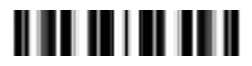


--- Iter 178 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.610578580351395
Current FOM: 1.1830422645396805
Binary degree : 0.704185350216307 


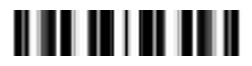


--- Iter 179 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.610578580351395
Current FOM: 1.182881120230129
Binary degree : 0.7025026319850246 


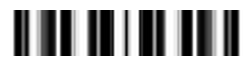


--- Iter 180 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.610578580351395
Current FOM: 1.1939737253639828
Binary degree : 0.7012768117137285 


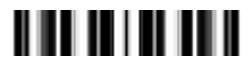


--- Iter 181 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.610578580351395
Current FOM: 1.2177488101485079
Binary degree : 0.699949881585738 


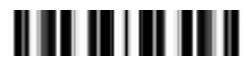


--- Iter 182 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.610578580351395
Current FOM: 1.2146167282795126
Binary degree : 0.6989327658175117 


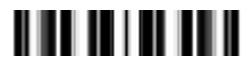


--- Iter 183 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.610578580351395
Current FOM: 1.2640286862724173
Binary degree : 0.6990973862675753 


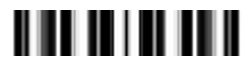


--- Iter 184 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.610578580351395
Current FOM: 1.1653524581577483
Binary degree : 0.6994856232623752 


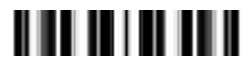


--- Iter 185 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.610578580351395
Current FOM: 1.1269381035060237
Binary degree : 0.698871214782926 


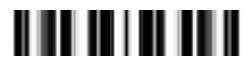


--- Iter 186 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.610578580351395
Current FOM: 1.2348155521805124
Binary degree : 0.6976769909745765 


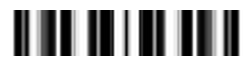


--- Iter 187 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.610578580351395
Current FOM: 1.22463864994573
Binary degree : 0.6963431079429296 


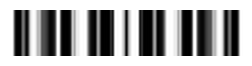


--- Iter 188 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.610578580351395
Current FOM: 1.23670714719331
Binary degree : 0.6951714939955916 


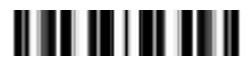


--- Iter 189 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.610578580351395
Current FOM: 1.2493447677424925
Binary degree : 0.6951155205361182 


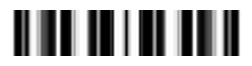


--- Iter 190 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.610578580351395
Current FOM: 1.2247438627030116
Binary degree : 0.6957991738515574 


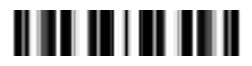


--- Iter 191 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.610578580351395
Current FOM: 1.2509521449993442
Binary degree : 0.6962169081672536 


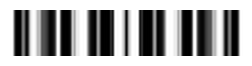


--- Iter 192 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.610578580351395
Current FOM: 1.218290962860567
Binary degree : 0.6967198529926241 


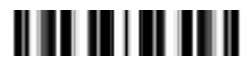


--- Iter 193 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.610578580351395
Current FOM: 1.1951515162005137
Binary degree : 0.6968912131902458 


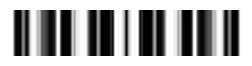


--- Iter 194 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.610578580351395
Current FOM: 1.2558770158511912
Binary degree : 0.6961162853764186 


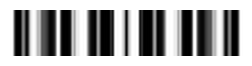


--- Iter 195 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.610578580351395
Current FOM: 1.2630818403199695
Binary degree : 0.695418546752657 


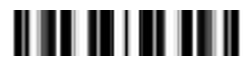


--- Iter 196 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.610578580351395
Current FOM: 1.2455551894006363
Binary degree : 0.6952656920115958 


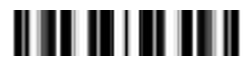


--- Iter 197 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.610578580351395
Current FOM: 1.2656328027170343
Binary degree : 0.6950304932229421 


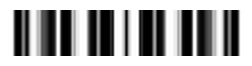


--- Iter 198 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.610578580351395
Current FOM: 1.2663175470616312
Binary degree : 0.694969909774855 


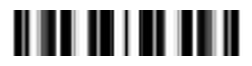


--- Iter 199 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.610578580351395
Current FOM: 1.2548874842401359
Binary degree : 0.6953768176689277 


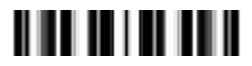


--- Iter 200 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.610578580351395
Current FOM: 1.2371567604925526
Binary degree : 0.6954139462315287 


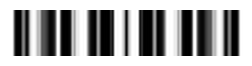


--- Iter 201 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.610578580351395
Current FOM: 1.246599706853739
Binary degree : 0.6948501826642729 


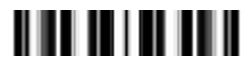


--- Iter 202 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.610578580351395
Current FOM: 1.2679023402738083
Binary degree : 0.694239632913818 


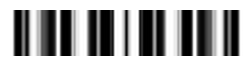


--- Iter 203 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.610578580351395
Current FOM: 1.2696661245851948
Binary degree : 0.6936493906744156 


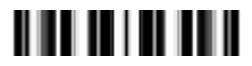


--- Iter 204 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.610578580351395
Current FOM: 1.274903149909316
Binary degree : 0.6933047411729618 


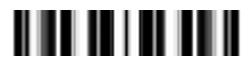


--- Iter 205 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.7160918427257807
Current FOM: 1.2719527547086216
Binary degree : 0.6934980123927155 


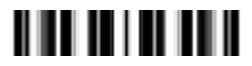


--- Iter 206 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.826878299479995
Current FOM: 1.1365532731954124
Binary degree : 0.6982714293236731 


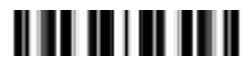


--- Iter 207 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.826878299479995
Current FOM: 1.1069979554745966
Binary degree : 0.7017943298058364 


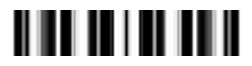


--- Iter 208 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.826878299479995
Current FOM: 1.2324821760697628
Binary degree : 0.7012626662766098 


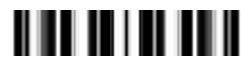


--- Iter 209 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.826878299479995
Current FOM: 1.0857572633007477
Binary degree : 0.7015290541700017 


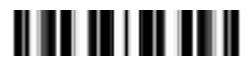


--- Iter 210 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.826878299479995
Current FOM: 1.230581002823674
Binary degree : 0.7004371584497416 


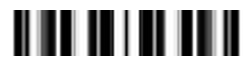


--- Iter 211 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.826878299479995
Current FOM: 1.1939302076264708
Binary degree : 0.6998507417452177 


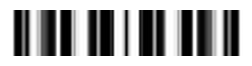


--- Iter 212 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.826878299479995
Current FOM: 1.23796030235328
Binary degree : 0.700383879268262 


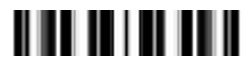


--- Iter 213 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.826878299479995
Current FOM: 1.221325036946746
Binary degree : 0.7002455425871366 


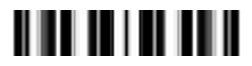


--- Iter 214 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.826878299479995
Current FOM: 1.1235478183296668
Binary degree : 0.6994327156462051 


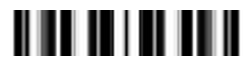


--- Iter 215 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.826878299479995
Current FOM: 1.2136381690099218
Binary degree : 0.6995672909779213 


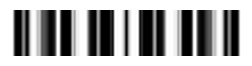


--- Iter 216 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.826878299479995
Current FOM: 1.2502720227935689
Binary degree : 0.6989265166228991 


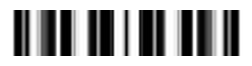


--- Iter 217 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.826878299479995
Current FOM: 1.2372809050275932
Binary degree : 0.6979995552140312 


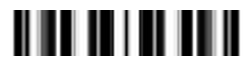


--- Iter 218 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.826878299479995
Current FOM: 1.253360342211074
Binary degree : 0.6982258713310672 


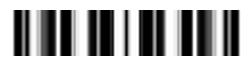


--- Iter 219 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.826878299479995
Current FOM: 1.221538544941206
Binary degree : 0.6985943109471866 


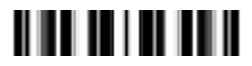


--- Iter 220 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.826878299479995
Current FOM: 1.2537899181662557
Binary degree : 0.6979735249364561 


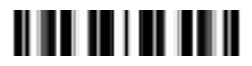


--- Iter 221 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.826878299479995
Current FOM: 1.2458625630269575
Binary degree : 0.6983246914667606 


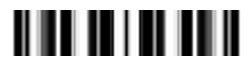


--- Iter 222 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.826878299479995
Current FOM: 1.1844752544951092
Binary degree : 0.6988767350693192 


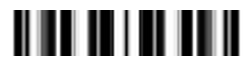


--- Iter 223 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.826878299479995
Current FOM: 1.2429223513075034
Binary degree : 0.6980672314581858 


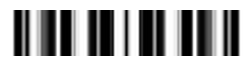


--- Iter 224 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.826878299479995
Current FOM: 1.274242844614831
Binary degree : 0.6981297942495747 


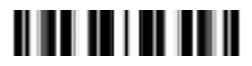


--- Iter 225 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.826878299479995
Current FOM: 1.2402646183862323
Binary degree : 0.6986132959827341 


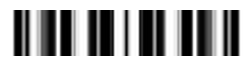


--- Iter 226 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.826878299479995
Current FOM: 1.2804279670777345
Binary degree : 0.6980113484762034 


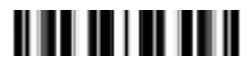


--- Iter 227 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.826878299479995
Current FOM: 1.2816757209145504
Binary degree : 0.6978114335777613 


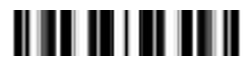


--- Iter 228 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.826878299479995
Current FOM: 1.252246026810897
Binary degree : 0.6981789510265952 


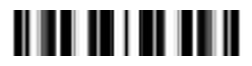


--- Iter 229 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.826878299479995
Current FOM: 1.250960906314146
Binary degree : 0.6976191876488822 


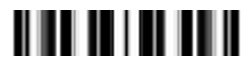


--- Iter 230 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.826878299479995
Current FOM: 1.2566104490326742
Binary degree : 0.6973007584609705 


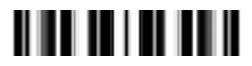


--- Iter 231 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.2655012277121096
Binary degree : 0.6974221389173699 


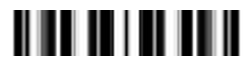


--- Iter 232 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.2034115433361083
Binary degree : 0.70167943668879 


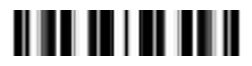


--- Iter 233 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 0.9992894489053785
Binary degree : 0.6995612623080442 


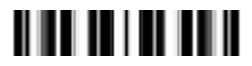


--- Iter 234 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.2392670780798423
Binary degree : 0.6997487970355494 


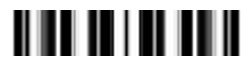


--- Iter 235 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 0.8661247509144401
Binary degree : 0.7011467021283827 


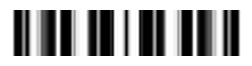


--- Iter 236 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.2523117580451149
Binary degree : 0.6996956781181762 


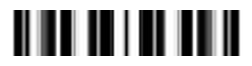


--- Iter 237 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 0.905732816896512
Binary degree : 0.6980898070802197 


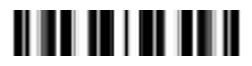


--- Iter 238 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.1368726482577565
Binary degree : 0.6982763880096677 


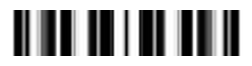


--- Iter 239 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 0.9050662496749644
Binary degree : 0.6995687162062596 


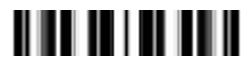


--- Iter 240 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.1195592353554427
Binary degree : 0.6989698131898799 


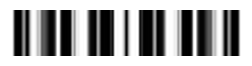


--- Iter 241 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 0.9676633535227632
Binary degree : 0.6970174423011387 


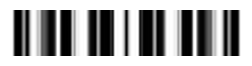


--- Iter 242 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 0.9123916665802377
Binary degree : 0.6966068084959043 


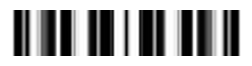


--- Iter 243 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.277930853848114
Binary degree : 0.6974220343272154 


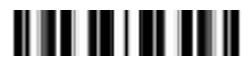


--- Iter 244 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 0.8939036179034162
Binary degree : 0.69834950566793 


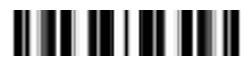


--- Iter 245 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.2543165094090987
Binary degree : 0.6972019623516786 


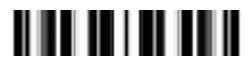


--- Iter 246 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.0170990119781715
Binary degree : 0.6957433205494137 


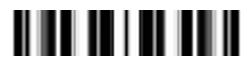


--- Iter 247 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.1146408039196931
Binary degree : 0.6957607745657033 


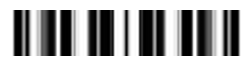


--- Iter 248 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.1625439984710777
Binary degree : 0.6970068525548251 


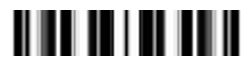


--- Iter 249 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.1032589006911928
Binary degree : 0.6970384196360982 


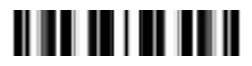


--- Iter 250 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.251777580152775
Binary degree : 0.6954114945379565 


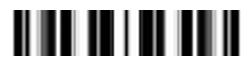


--- Iter 251 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.1568188352752835
Binary degree : 0.6948953409161917 


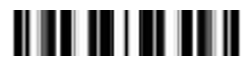


--- Iter 252 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.2888866792817482
Binary degree : 0.695583578351898 


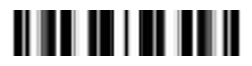


--- Iter 253 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.1462501861401329
Binary degree : 0.6960573794575499 


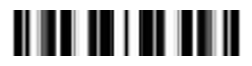


--- Iter 254 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.297703865093877
Binary degree : 0.6950324751032457 


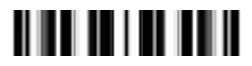


--- Iter 255 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.1938569809750128
Binary degree : 0.6943267561359228 


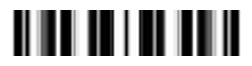


--- Iter 256 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.3014056891920902
Binary degree : 0.6948303886550775 


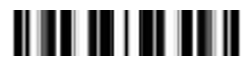


--- Iter 257 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.2007977564868693
Binary degree : 0.6957085165837932 


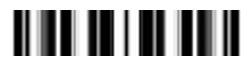


--- Iter 258 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.3026087866804568
Binary degree : 0.6951472460167092 


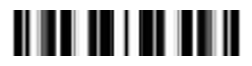


--- Iter 259 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.239930050246381
Binary degree : 0.6945734224623028 


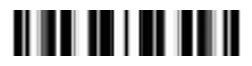


--- Iter 260 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.3007986010357215
Binary degree : 0.6954346940824634 


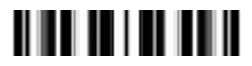


--- Iter 261 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.227069529674838
Binary degree : 0.6964992921492924 


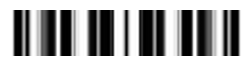


--- Iter 262 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.2921035224340203
Binary degree : 0.6962915889768005 


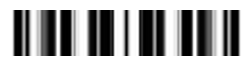


--- Iter 263 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.250935936460667
Binary degree : 0.6959312645290389 


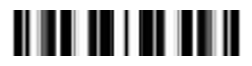


--- Iter 264 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.300935477237602
Binary degree : 0.6967857067035707 


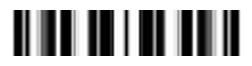


--- Iter 265 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.2514303701915153
Binary degree : 0.6976938822498023 


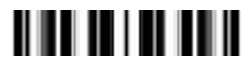


--- Iter 266 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.3017837571229962
Binary degree : 0.6975582345716617 


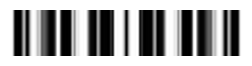


--- Iter 267 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.2784594336536057
Binary degree : 0.6973008412144573 


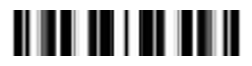


--- Iter 268 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.2993914634556865
Binary degree : 0.6979062900280776 


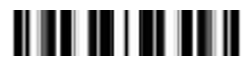


--- Iter 269 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.2571025055817153
Binary degree : 0.6985621463923748 


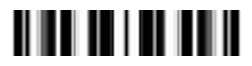


--- Iter 270 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.289651070824179
Binary degree : 0.6983349793735426 


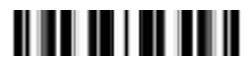


--- Iter 271 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.274535452137532
Binary degree : 0.6981245504462975 


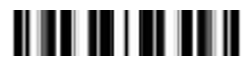


--- Iter 272 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.2967706026260928
Binary degree : 0.6986611568797441 


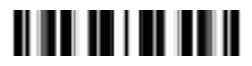


--- Iter 273 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.2755774358343415
Binary degree : 0.6990819556651485 


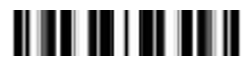


--- Iter 274 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.301685936979893
Binary degree : 0.6988555292435519 


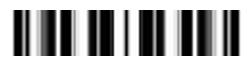


--- Iter 275 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.2907946464728475
Binary degree : 0.6990266936548165 


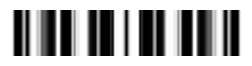


--- Iter 276 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.2891205318959005
Binary degree : 0.6997311260162525 


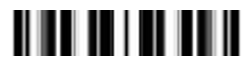


--- Iter 277 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.2742642612307546
Binary degree : 0.7002820645533976 


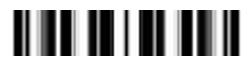


--- Iter 278 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.284006900911031
Binary degree : 0.700597901146378 


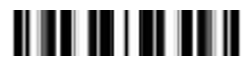


--- Iter 279 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.2885887569440069
Binary degree : 0.7009577126250824 


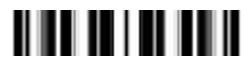


--- Iter 280 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.9432012213957317
Current FOM: 1.2847466662785088
Binary degree : 0.7014701739959719 


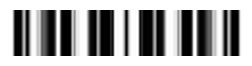


--- Iter 281 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.0653369815421128
Current FOM: 1.2917911467470584
Binary degree : 0.7018116408624284 


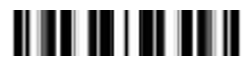


--- Iter 282 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.0653369815421128
Current FOM: 1.2112937072112984
Binary degree : 0.7071827696734393 


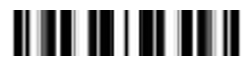


--- Iter 283 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.0653369815421128
Current FOM: 1.1494284197465674
Binary degree : 0.7071362784670494 


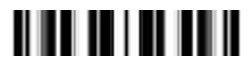


--- Iter 284 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.0653369815421128
Current FOM: 1.2808120718164708
Binary degree : 0.7070941482310599 


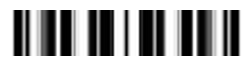


--- Iter 285 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.0653369815421128
Current FOM: 1.134543201110071
Binary degree : 0.7075833619894373 


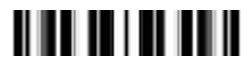


--- Iter 286 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.0653369815421128
Current FOM: 1.2716465013595708
Binary degree : 0.7074313666509506 


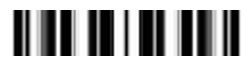


--- Iter 287 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.0653369815421128
Current FOM: 1.2081509352724438
Binary degree : 0.7073909111949934 


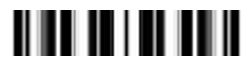


--- Iter 288 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.0653369815421128
Current FOM: 1.2858335639937972
Binary degree : 0.7076714397424642 


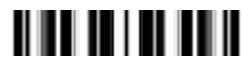


--- Iter 289 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.0653369815421128
Current FOM: 1.1441268452916762
Binary degree : 0.7080707770826267 


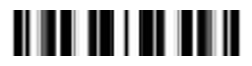


--- Iter 290 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.0653369815421128
Current FOM: 1.24392663797106
Binary degree : 0.7083839139525651 


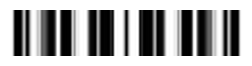


--- Iter 291 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.0653369815421128
Current FOM: 1.1846593470067726
Binary degree : 0.7085346045663756 


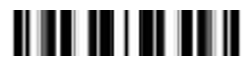


--- Iter 292 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.0653369815421128
Current FOM: 1.2848340967246312
Binary degree : 0.7084059058984352 


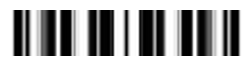


--- Iter 293 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.0653369815421128
Current FOM: 1.2066494168716047
Binary degree : 0.7085295904514314 


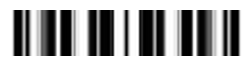


--- Iter 294 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.0653369815421128
Current FOM: 1.285126251788905
Binary degree : 0.7086374528961038 


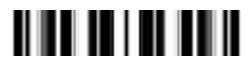


--- Iter 295 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.0653369815421128
Current FOM: 1.2647994970256349
Binary degree : 0.7091190929751426 


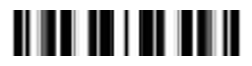


--- Iter 296 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.0653369815421128
Current FOM: 1.2820579626514803
Binary degree : 0.7097649962115468 


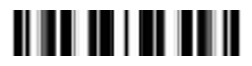


--- Iter 297 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.0653369815421128
Current FOM: 1.2322505364231673
Binary degree : 0.7104886184495425 


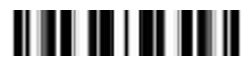


--- Iter 298 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.0653369815421128
Current FOM: 1.2292421360437435
Binary degree : 0.7110761764005321 


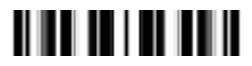


--- Iter 299 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.0653369815421128
Current FOM: 1.2654939463955075
Binary degree : 0.7112991970256143 


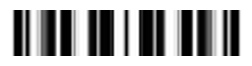


--- Iter 300 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 3.0653369815421128
Current FOM: 1.2679122426492138
Binary degree : 0.711310060452174 


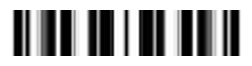

In [60]:
# n = Nx*layer_num
# x = np.ones(n) * 0.5

n = Nx * layer_num
np.random.seed(3)           # (선택) 재현 가능한 결과를 원할 때 시드 고정
x = np.random.rand(n)  

cur_beta = 2

cur_iter             = [0]
evaluation_history   = []
beta_history         = []
binarization_history = []

g_histories   = [[] for _ in range(layer_num)]
x_histories   = [[] for _ in range(layer_num)]
lr_histories  = [[] for _ in range(layer_num)]
uf_histories  = [[] for _ in range(layer_num)]
t_histories   = [[] for _ in range(layer_num)]

optimizers = [AdamOptimizer(lr=0.02, beta1=0.9) for _ in range(layer_num)]

def f_multi(v, eta, beta):
    print(f"\n--- Iter {cur_iter[0]+1} ---")

    rho_full = multi_mapping(v, eta, beta)

    bin_deg = np.sum(np.abs(rho_full - 0.5)) / (0.5 * rho_full.size)
    binarization_history.append(bin_deg)

    size_each = Nx*Ny
    rho_list = [rho_full[i*size_each:(i+1)*size_each]
                for i in range(layer_num)]

    f0, dJ_du = opt(rho_list,
                    need_value=True,
                    need_gradient=True,
                    beta=beta)
    
    if not isinstance(dJ_du, (list, tuple)):
        dJ_du = [dJ_du]

    dJ_flat = np.concatenate([np.array(d).flatten() for d in dJ_du])

    gradient_full = tensor_jacobian_product(multi_mapping_ad, 0)(
        v, eta_i, beta, dJ_flat
    )

    grad_list = [gradient_full[i*size_each:(i+1)*size_each]
                 for i in range(layer_num)]
    
    vs = v.reshape(layer_num, size_each)
    v_new_layers = []
    for i in range(layer_num):
        vi_new, lr, uf, m, vt, t = optimizers[i].update(vs[i], grad_list[i])
        lr_histories[i].append(lr)
        uf_histories[i].append(uf)
        t_histories[i].append(t)
        g_histories[i].append(grad_list[i].copy())
        x_histories[i].append(vi_new.copy())
        v_new_layers.append(vi_new)

    v_new = np.concatenate(v_new_layers)

    # beta_new = beta + 5*np.tanh((beta - 0.5)*0.01)

    f_val = float(np.real(f0))

    beta_new = beta  # 기본값은 그대로
    if len(evaluation_history) >= 3:
        # 최근 3개 값: [n-3] [n-2] [n-1] (0-based indexing)
        f_prev2 = evaluation_history[-3]
        f_prev1 = evaluation_history[-2]
        f_curr  = evaluation_history[-1]

        # 변화율 계산
        change1 = abs(f_curr  - f_prev1) / (abs(f_prev1) + 1e-12)
        change2 = abs(f_prev1 - f_prev2) / (abs(f_prev2) + 1e-12)

        # 둘 다 0.5% 미만이면 β를 1.2배로
        if change1 < 0.005 and change2 < 0.005:
            beta_new = beta + 5*np.tanh((beta - 0.5)*0.01)

    evaluation_history.append(f_val)
    beta_history.append(beta_new)
    cur_iter[0] += 1

    print("Current beta: {}".format(beta_new))
    print("Current FOM: {}".format(f0))
    print("Binary degree : {} ".format(bin_deg))

    plt.figure(figsize=(3,2))
    ax = plt.gca()
    opt.plot2D(
        False,
        output_plane=mp.Volume(
            size=mp.Vector3(design_region_width,region_height_each*layer_num-1/resolution,0),
            center=mp.Vector3(0, full_center_y,0)
        ),
        ax=ax,
        show_sources=False,
        show_monitors=False,
        show_boundary_layers=False,
    )
    ax.axis("off")
    plt.show()

    return v_new, beta_new

mp.verbosity(0)
Max_iter = 300
# Main loop (변경 없음)
while cur_iter[0] < Max_iter:
    x, cur_beta = f_multi(x, eta_i, cur_beta)
    if binarization_history[-1] > 0.98:
        print("Threshold reached → final mapping with β=∞")
        x, _ = f_multi(x, eta_i, np.inf)
        break

In [296]:
# 1) 배열로 변환
eval_hist = np.array(evaluation_history)

# 2) 최대값과 그 인덱스 찾기 (0-based)
max_val   = eval_hist.max()
max_idx0  = eval_hist.argmax()

# 3) 사람이 셀 때 보통 1부터 시작하니 +1
iteration = max_idx0 + 1

print(f"최대 FoM = {max_val:.6f} 는 iteration {iteration} 에서 나왔습니다.")

최대 FoM = 0.025534 는 iteration 148 에서 나왔습니다.


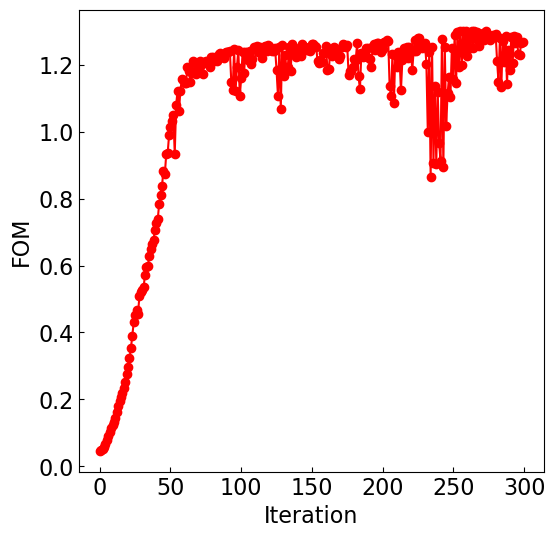

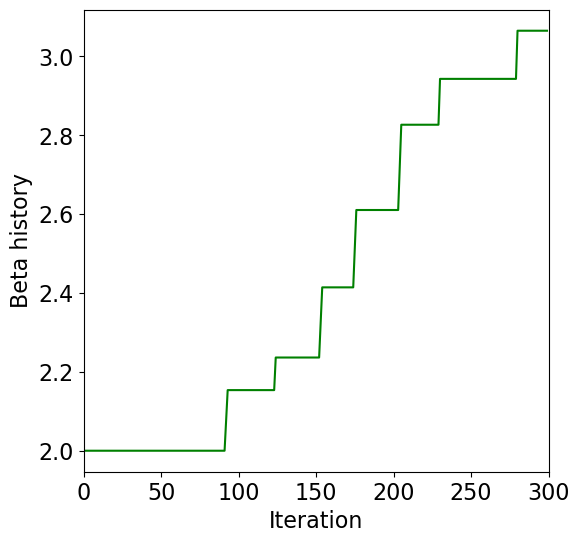

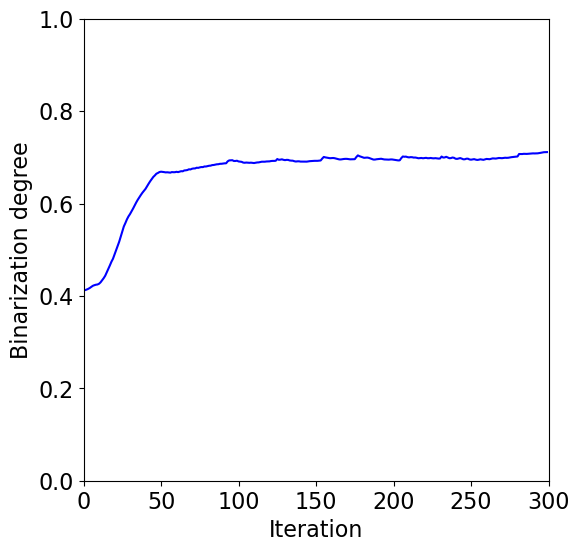

In [77]:
################ FOM plot ################ 
plt.figure(figsize = (6,6))
plt.plot(evaluation_history, 'or-')
plt.xlabel('Iteration',fontsize = 16)
plt.ylabel('FOM',fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tick_params(direction = 'in')
plt.show()

################ beta history plot ################ 
plt.figure(figsize = (6,6))
plt.plot(beta_history, 'g-')
plt.xlabel('Iteration',fontsize = 16)
plt.ylabel('Beta history',fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlim(0, np.array(cur_iter))
plt.show()

################ Binarization degree plot ################ 
plt.figure(figsize = (6,6))
plt.plot(binarization_history, 'b-')
plt.xlabel('Iteration',fontsize = 16)
plt.ylabel('Binarization degree',fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlim(0, np.array(cur_iter))
plt.ylim(0,1)
plt.show()

In [147]:
# multi2 = design_variables[0].weights
# multi1 = design_variables[1].weights
# k = design_variables.weights
# opt.update_design([k])
opt.update_design([multi2, multi1])

(-1.2, 1.2, 1.01, 1.99)

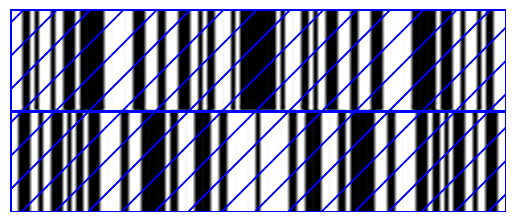

In [149]:
opt.plot2D(
    True,
    output_plane = mp.Volume(size = mp.Vector3(design_region_width, design_region_height-1/resolution, 0), center = mp.Vector3(0, full_center_y,0)),
    
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
)
plt.axis(False)

     block, center = (0,-3,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.75,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.75,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.75,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.5,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)


(-1.2, 1.2, 1.26, 1.74)

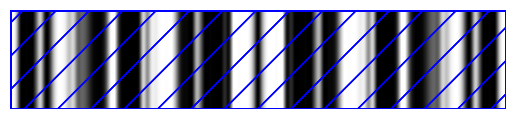

In [90]:
opt.plot2D(
    True,
    output_plane = mp.Volume(size = mp.Vector3(design_region_width, design_region_height-1/resolution, 0), center = mp.Vector3(0, full_center_y,0)),
    
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
)
plt.axis(False)

     block, center = (0,-3,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.75,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.75,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.75,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.5,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)


<Axes: xlabel='X', ylabel='Y'>

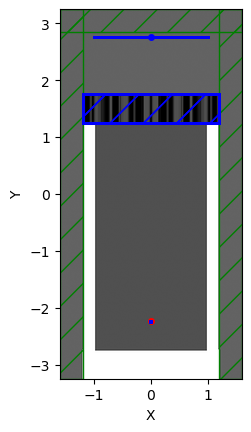

In [91]:
offset = 0.01
flux_size = 0.02
mn_size = 2

monitor_position_y, monitor_size = mp.Vector3(0, center_y_monitor_position), mp.Vector3(mn_size,0)

#### input source의 flux ####
input_flux = opt.sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=sources.center - mp.Vector3(offset, 0, 0),
                    size=mp.Vector3(0, flux_size),
                    # direction=mp.X, 
                    weight=-1),
        mp.FluxRegion(center=sources.center + mp.Vector3(offset, 0, 0),
                    size=mp.Vector3(0, flux_size),
                    # direction=mp.X
                    ),
        mp.FluxRegion(center=sources.center - mp.Vector3(0, offset, 0),
                    size=mp.Vector3(flux_size, 0),
                    # direction=mp.Y, 
                    weight=-1),
        mp.FluxRegion(center=sources.center + mp.Vector3(0, offset, 0),
                    size=mp.Vector3(flux_size, 0),
                    # direction=mp.Y
                    )
    )

#### output flux -> add flux로 계산한 poynting vector ####
out_flux = opt.sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(
                center=monitor_position_y,
                size=monitor_size,
                # direction=mp.Y
                # weight=-1
        )
    )

#### output flux -> 성분별 field를 뽑고, poynting vector를 계산할 예정 ####
dft_fields = opt.sim.add_dft_fields([mp.Ex, mp.Ey, mp.Ez, mp.Hx, mp.Hy, mp.Hz], fcen, 0, 1, 
                                    center = monitor_position_y,
                                    size = monitor_size, 
                                    yee_grid=True)

opt.sim.plot2D()


-----------
Initializing structure...
time for choose_chunkdivision = 3.60012e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.5 x 0 with resolution 50
     block, center = (0,-3,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.75,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.75,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.75,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.5,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0553899 s
time for set_conductivity = 0.00208902 s
time for set_conduc

/home/min/miniconda3/envs/mp/lib/python3.11/site-packages/meep/visualization.py:284: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


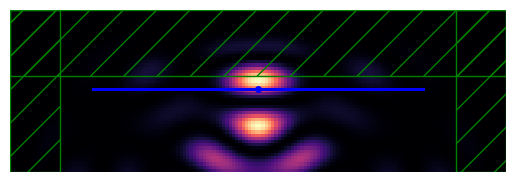

In [92]:
mp.verbosity(1)
sim.run(until_after_sources=mp.stop_when_fields_decayed(10/df, mp.Ez, sources.center, 1e-5))
# sim.run(until_after_sources=mp.stop_when_dft_decayed(1e-3))

opt.sim.plot2D(
    fields=mp.Ez,
    output_plane=mp.Volume(
    center = monitor_position_y,
    size = mp.Vector3(3, 1)),
    field_parameters={
        'post_process': lambda x: np.abs(np.real(x))**2,  # 복소수 필드 x → intensity |x|^2
        'cmap': 'magma',                         # 원하시는 colormap
        'alpha': 1,                            # 투명도
        'interpolation': 'none'
    },
    eps_parameters={'cmap':'magma','alpha':0.5}
)
plt.axis(False)
plt.show()

     block, center = (0,-3,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.75,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.75,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.75,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.5,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)


/home/min/miniconda3/envs/mp/lib/python3.11/site-packages/meep/visualization.py:284: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


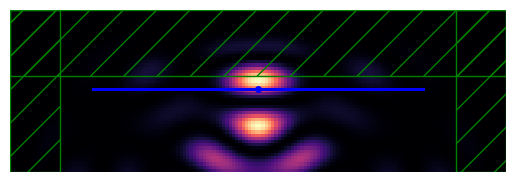

In [97]:
opt.sim.plot2D(
    fields=mp.Ez,
    output_plane=mp.Volume(
    center = monitor_position_y,
    size = mp.Vector3(3, 1)),
    field_parameters={
        'post_process': lambda x: np.abs(x)**2,  # 복소수 필드 x → intensity |x|^2
        'cmap': 'magma',                         # 원하시는 colormap
        'alpha': 1,                            # 투명도
        'interpolation': 'none'
    },
    eps_parameters={'cmap':'magma','alpha':0.5}
)
plt.axis(False)
plt.show()

     block, center = (0,-3,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.75,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.75,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.75,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.5,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)


<Axes: xlabel='X', ylabel='Y'>

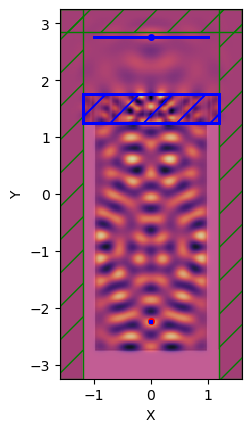

In [87]:
opt.sim.plot2D(fields = mp.Ez,
               
           field_parameters={
        'cmap': 'magma',    # magma 컬러맵 지정
        'alpha': 0.8,       # 필드 투명도 (0.0~1.0)
        'interpolation': 'none'
    }
)

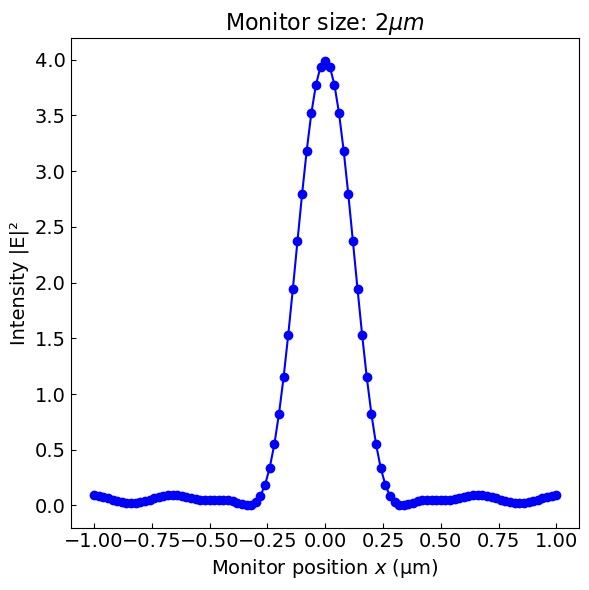

In [98]:
external_field_array = np.abs(sim.get_dft_array(dft_fields, mp.Ez, 0))

N = len(external_field_array)
W = mn_size                           # μm 단위 모니터 폭
x = np.linspace(-W/2, W/2, N)                     # μm 단위 위치
z = abs(center_y_monitor_position - center_y_source_position)  # μm 단위 거리

# 3) Intensity 계산
I = np.abs(external_field_array)**2

# 4) θ 축으로 플롯
plt.figure(figsize=(6,6))
plt.plot(x, I, 'bo-')


plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
plt.ylabel('Intensity |E|²',       fontsize=14)
# plt.ylabel('phase',       fontsize=14)
plt.title(r'Monitor size: $2\mu m$', fontsize=16)
plt.tick_params(direction = 'in')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tight_layout()
plt.show()

In [99]:
eqe = mp.get_fluxes(out_flux)[0]/mp.get_fluxes(input_flux)[0]*100

print("Input flux :", mp.get_fluxes(input_flux)[0])
print("Output flux :", mp.get_fluxes(out_flux)[0])
print("EQE(%) :", eqe,"%")

Input flux : 1.4862238406363701
Output flux : 1.0633035492352916
EQE(%) : 71.54397071036131 %


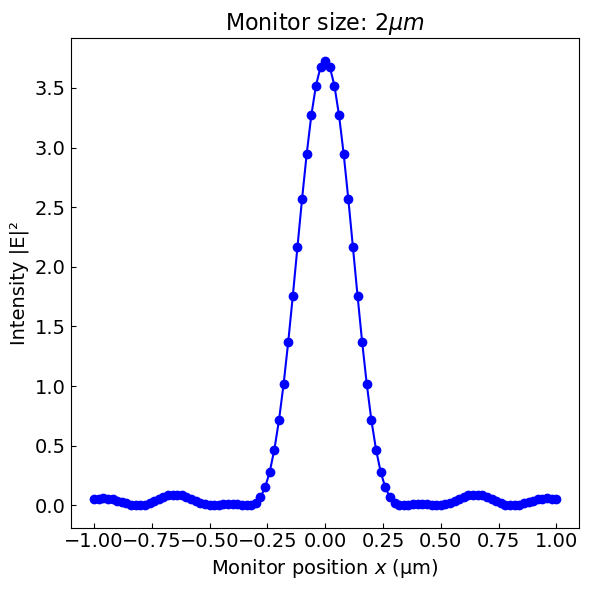

In [100]:
external_field_array = np.real(sim.get_dft_array(dft_fields, mp.Ez, 0))

N = len(external_field_array)
W = mn_size                           # μm 단위 모니터 폭
x = np.linspace(-W/2, W/2, N)                     # μm 단위 위치
z = abs(center_y_monitor_position - center_y_source_position)  # μm 단위 거리

# 3) Intensity 계산
I = np.abs(external_field_array)**2

# 4) θ 축으로 플롯
plt.figure(figsize=(6,6))
plt.plot(x, I, 'bo-')


plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
plt.ylabel('Intensity |E|²',       fontsize=14)
# plt.ylabel('phase',       fontsize=14)
plt.title(r'Monitor size: $2\mu m$', fontsize=16)
plt.tick_params(direction = 'in')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tight_layout()
plt.show()

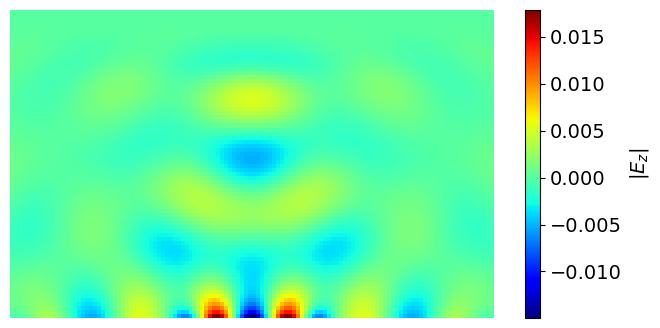

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import meep as mp

nx = int(design_region_resolution * design_region_width) + 1
x_res = np.linspace(-design_region_width/2,
                     design_region_width/2,
                     nx)

y_start = center_y_design + design_region_height/2
y_end   = center_y_monitor_position + 1/fcen
ny = int(design_region_resolution * (y_end - y_start)) + 1
y_res = np.linspace(y_start, y_end, ny)

vol = mp.Volume(
    center=mp.Vector3(0, (y_start + y_end)/2, 0),
    size=  mp.Vector3(design_region_width,
                      y_end - y_start,
                      0)
)
Ez_slice = opt.sim.get_array(mp.Ez, vol).T   # shape == (ny, nx)

plt.figure(figsize=(8,4))
plt.imshow(
    np.real(Ez_slice),      # (ny, nx)
    origin='lower',
    extent=[x_res.min(), x_res.max(), y_res.min(), y_res.max()],
    aspect='equal',
    cmap='jet'
)

cbar = plt.colorbar()
cbar.set_label(r'$|E_z|$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

# plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
# plt.ylabel('Height $y$ (µm)',           fontsize=14)
# plt.title(r'Monitor size: $2\ \mu m$',   fontsize=16)

# 틱 폰트 크기 및 방향 맞추기
plt.tick_params(direction='in', labelsize=14)
# plt.tight_layout()
plt.axis('off')
plt.show()

In [105]:
import numpy as np

I = np.real(external_field_array)**2
N = len(I)
W = mn_size
x = np.linspace(-W/2, W/2, N)
z = abs(center_y_monitor_position - center_y_source_position)

center_idx = np.argmax(I)
# 간단히 for문으로
for i in range(center_idx+1, N-1):
    if I[i] < I[i-1] and I[i] < I[i+1]:
        x_limit = abs(x[i])
        break
else:
    raise RuntimeError("1차 링 경계를 찾을 수 없음")

x_min, x_max = -x_limit, x_limit

mask = (x >= x_min) & (x <= x_max)

x_slice = x[mask]
I_slice = I[mask]

dx = x[1] - x[0]
flux_slice = np.sum(I_slice) * dx   

input = np.array(mp.get_fluxes(input_flux))[0]
output = np.array(mp.get_fluxes(out_flux))[0]

print("Input flux :", input)
print("Output flux :", output)
print(f"±{x_limit:.3f} µm 구간 integrated intensity: {flux_slice}")

optical_eqe = flux_slice/input * 100
print("1차 ring까지의 Optical EQE :", optical_eqe,"%")

Input flux : 1.4862238406363701
Output flux : 1.0633035492352916
±0.340 µm 구간 integrated intensity: 1.0340009504704253
1차 ring까지의 Optical EQE : 69.57235661269486 %


In [106]:
import numpy as np

# 1) 강도 계산
I = np.abs(external_field_array)**2
N = len(I)
W = mn_size
x = np.linspace(-W/2, W/2, N)
center_idx = np.argmax(I)

# 2) 첫 번째 링 경계: 미분으로 valley 찾기
dI = np.diff(I)
valleys = np.where((dI[:-1] < 0) & (dI[1:] > 0))[0] + 1
valleys = valleys[valleys > center_idx]
if valleys.size == 0:
    raise RuntimeError("1차 링 경계를 찾을 수 없음")
idx_valley = valleys[0]
x_limit = abs(x[idx_valley])

# 3) 적분 구간 설정
mask = (x >= -x_limit) & (x <= x_limit)
dx = x[1] - x[0]
flux_slice = np.sum(I[mask]) * dx

# 4) Flux 모니터 값
input_flux  = np.array(mp.get_fluxes(input_flux))[0]
output_flux = np.array(mp.get_fluxes(out_flux))[0]

# 5) Optical EQE 계산: 출력 flux 비율을 사용
optical_eqe = output_flux / input_flux * 100

print(f"±{x_limit:.3f} µm 구간 intensity 적분: {flux_slice:.4f}")
print(f"모니터 기반 Optical EQE: {optical_eqe:.2f}%")


±0.340 µm 구간 intensity 적분: 1.0340
모니터 기반 Optical EQE: 71.54%


In [287]:
eqe = mp.get_fluxes(out_flux)[0]/mp.get_fluxes(input_flux)[0]*100
    
print("Input flux :", mp.get_fluxes(input_flux)[0])
print("Output flux :", mp.get_fluxes(out_flux)[0])
print("EQE(%) :", eqe,"%")

AttributeError: 'numpy.float64' object has no attribute 'flux'